# Visualization of Stock Trading

In [56]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import datetime
import pandas_datareader.data as web


import matplotlib.pyplot as plt

import logging
import coloredlogs

from train import *
from evaluate import show_eval_result

# Altair:
# in case of error on notebook: Istll vega_datasets
#conda install -c conda-forge altair vega_datasets notebook vega
#see also https://altair-viz.github.io/getting_started/installation.html
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Set relevant parameters

In [7]:
#train_stock = 'data/GOOGL.csv'
#val_stock = 'data/AAPL_2018.csv'
window_size = 10
batch_size = 16
ep_count = 50 # for debugging, otherwise 15-50
model_name = 'model_Stefan2'
pretrained = False
debug = False

## Load Datasets into pandas DataFrame

In [4]:
# read csv into dataframe
#df = pd.read_csv(val_stock)

# Setting Start and Enddate for Validation
start_train= datetime.datetime(2012, 1, 1)
end_train = datetime.datetime(2018, 1, 1)
start_val = end_train
end_val = datetime.datetime.now()


# Load Training and Validation data
# 1st. dataset as trading target
# 2nd. dataset as additional input feature

df_train = web.DataReader('AAPL','yahoo',
                               start=start_train, #start_train
                               end=end_train)  #end_train

df2_train = web.DataReader('GOLD','yahoo',
                               start=start_train, #start_train
                               end=end_train) #end_train


df_val = web.DataReader('AAPL','yahoo',
                               start=start_val, #start_train
                               end=end_val) #end_val
df2_val = web.DataReader('GOLD','yahoo',
                               start=start_val, #start_val
                               end=end_val)  #end_val

df = df_val # will be used to show actions and for plotting

#rename feature column names
df = df.rename(columns={'Adj Close': 'actual'})


# filter out the desired features



# Generate list objects
df_train_list = list(df_train['Adj Close'])
df_val_list = list(df_val['Adj Close'])
df2_train_list = list(df2_train['Adj Close'])
df2_val_list = list(df2_val['Adj Close'])


# Deleting obsolete dataframes
del df_train
del df_val
del df2_train
del df2_val

df.head()

# Open tast: Clean datasets (Adj Close, data that is not necessary)

,High,Low,Open,Close,Volume,actual
Date,,,,,,
2018-01-02,172.300003,169.259995,170.160004,172.259995,25555900.0,167.701889
2018-01-03,174.550003,171.960007,172.529999,172.229996,29517900.0,167.672668
2018-01-04,173.470001,172.080002,172.539993,173.029999,22434600.0,168.451508
2018-01-05,175.369995,173.050003,173.440002,175.000000,23660000.0,170.369385
2018-01-08,175.610001,173.929993,174.350006,174.350006,20567800.0,169.736588


## Visualization of actions taken by Trading Bot

In [10]:
def visualize(df, history):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    #alt.Chart(df.reset_index()).mark_line().encode(x='index')
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df.reset_index()).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='Date:T', #'date:T'
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df.reset_index()).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('Date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
        #color=alt.Color('action', scale=alt.Scale(range=['blue', 'red']))
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title="your stock").properties(height=300, width=1000)
    
    return chart

## Training the model

In [6]:
coloredlogs.install(level='DEBUG')
switch_k_backend_device() #switches to CPU (acc. to author faster than GPU)


train_data = df_train_list  
val_data = df_val_list 
train_data2 = df2_train_list #None
val_data2 = df2_val_list # None



if train_data2 is not None:
    agent = Agent(window_size*2, pretrained=False, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=False, model_name=model_name)

initial_offset = val_data[1] - val_data[0]

reslist_t =[] # Train Reward for plotting
reslist_v = [] # Val Reward for plotting
for i in range(1, ep_count + 1): 
    train_result = train_model(agent, i, train_data, train_data2, ep_count=ep_count,
                                batch_size=batch_size, window_size=window_size)
    val_result, _ = evaluate_model(agent, val_data, val_data2, window_size, debug)
    show_train_result(train_result, val_result, initial_offset)
    reslist_t.append(train_result[2]) # append reward of training
    reslist_v.append(val_result)
  





I1001 21:49:37.185004 20704 train.py:156] switching to TensorFlow for CPU
2019-10-01 21:49:37 PC-Stefan root[9980] DEBUG switching to TensorFlow for CPU
W1001 21:49:37.219942 20704 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2019-10-01 21:49:37 PC-Stefan tensorflow[9980] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1001 21:49:37.236616 20704 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

2019-10-01 21:49:37 PC-Stefan tensorflow[9980] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site-pa

Episode 36/50: 100%|██████████| 1508/1508 [00:14<00:00, 106.53it/s]
I1001 21:58:11.956801 20704 train.py:147] Episode 36/50 - Train Position: +$222.17  Val Position: +$187.64  Train Loss: 0.1133  (~14.1504 secs)
2019-10-01 21:58:11 PC-Stefan root[9980] INFO Episode 36/50 - Train Position: +$222.17  Val Position: +$187.64  Train Loss: 0.1133  (~14.1504 secs)
Episode 37/50: 100%|██████████| 1508/1508 [00:14<00:00, 105.24it/s]
I1001 21:58:26.395276 20704 train.py:147] Episode 37/50 - Train Position: +$125.86  Val Position: +$132.29  Train Loss: 0.1321  (~14.3221 secs)
2019-10-01 21:58:26 PC-Stefan root[9980] INFO Episode 37/50 - Train Position: +$125.86  Val Position: +$132.29  Train Loss: 0.1321  (~14.3221 secs)
Episode 38/50: 100%|██████████| 1508/1508 [00:14<00:00, 106.04it/s]
I1001 21:58:40.740813 20704 train.py:147] Episode 38/50 - Train Position: +$233.25  Val Position: +$125.58  Train Loss: 0.1352  (~14.2151 secs)
2019-10-01 21:58:40 PC-Stefan root[9980] INFO Episode 38/50 - Train 

I1001 22:01:33.756973 20704 font_manager.py:1259] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2019-10-01 22:01:33 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
I1001 22:01:33.772598 20704 font_manager.py:1271] findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2019-10-01 22:01:33 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
I1001 22:01:33.772598 20704 font_manager.py:1271] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
2019-10-01 22:01:33 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
I1001 22:01:33.788215 20704 font_man

2019-10-01 22:01:33 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
I1001 22:01:33.928849 20704 font_manager.py:1271] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
2019-10-01 22:01:33 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
I1001 22:01:33.928849 20704 font_manager.py:1271] findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
2019-10-01 22:01:33 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
I1001 22:01:33.944475 20704 font_manager.py:1271] findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2019-10-01 22:01:33 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'cmtt

2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
I1001 22:01:34.147614 20704 font_manager.py:1271] findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal bold normal>) = 10.335
2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal bold normal>) = 10.335
I1001 22:01:34.147614 20704 font_manager.py:1271] findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal light normal>) = 10.24
2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal light normal>) = 10.24
I1001 22:01:34.147614 20704 font_manager.py:1271] findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) normal normal 400 normal>) = 10.05
2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) normal normal 400 normal>) =

2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal light normal>) = 11.24
I1001 22:01:34.553892 20704 font_manager.py:1271] findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal bold condensed>) = 6.8986363636363635
2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal bold condensed>) = 6.8986363636363635
I1001 22:01:34.553892 20704 font_manager.py:1271] findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
I1001 22:01:34.569518 20704 font_manager.py:1271] findfont: score(<Font 'Franklin Gothic Demi' (FRADM.TTF) normal normal demi normal>) = 10.24
2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Franklin Gothic Demi' (FRAD

2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
I1001 22:01:34.757031 20704 font_manager.py:1271] findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
I1001 22:01:34.772657 20704 font_manager.py:1271] findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
I1001 22:01:34.772657 20704 font_manager.py:1271] findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal light normal>) = 10.24
2019-10-01 22:01:34 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) norma

2019-10-01 22:01:35 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal bold normal>) = 10.335
I1001 22:01:35.147682 20704 font_manager.py:1271] findfont: score(<Font 'Rockwell' (ROCKBI.TTF) italic normal bold normal>) = 11.335
2019-10-01 22:01:35 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Rockwell' (ROCKBI.TTF) italic normal bold normal>) = 11.335
I1001 22:01:35.147682 20704 font_manager.py:1271] findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05
2019-10-01 22:01:35 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05
I1001 22:01:35.147682 20704 font_manager.py:1271] findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 7.613636363636363
2019-10-01 22:01:35 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Arial' (ARIALNI.TTF)

2019-10-01 22:01:35 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
I1001 22:01:35.366448 20704 font_manager.py:1271] findfont: score(<Font 'Eras Light ITC' (ERASLGHT.TTF) normal normal light normal>) = 10.24
2019-10-01 22:01:35 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Eras Light ITC' (ERASLGHT.TTF) normal normal light normal>) = 10.24
I1001 22:01:35.366448 20704 font_manager.py:1271] findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal medium normal>) = 10.145
2019-10-01 22:01:35 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal medium normal>) = 10.145
I1001 22:01:35.366448 20704 font_manager.py:1271] findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
2019-10-01 22:01:35 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Trebuchet MS' (trebuc.t

2019-10-01 22:01:36 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Calisto MT' (CALISTB.TTF) normal normal bold normal>) = 10.335
I1001 22:01:36.460271 20704 font_manager.py:1271] findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal bold normal>) = 11.335
2019-10-01 22:01:36 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal bold normal>) = 11.335
I1001 22:01:36.460271 20704 font_manager.py:1294] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\ProgramData\\Anaconda3\\envs\\2019\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
2019-10-01 22:01:36 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\ProgramData\\Anaconda3\\envs\\2019\\lib\\site-packages\\matplot

2019-10-01 22:01:36 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Snap ITC' (SNAP____.TTF) normal normal 400 normal>) = 10.05
I1001 22:01:36.819679 20704 font_manager.py:1271] findfont: score(<Font 'Tw Cen MT Condensed Extra Bold' (TCCEB.TTF) normal normal bold condensed>) = 10.535
2019-10-01 22:01:36 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Tw Cen MT Condensed Extra Bold' (TCCEB.TTF) normal normal bold condensed>) = 10.535
I1001 22:01:36.835305 20704 font_manager.py:1271] findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
2019-10-01 22:01:36 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
I1001 22:01:36.835305 20704 font_manager.py:1271] findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal bold normal>) = 10.335
2019-10-01 22:01:36 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 

2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
I1001 22:01:37.179078 20704 font_manager.py:1271] findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
I1001 22:01:37.179078 20704 font_manager.py:1271] findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 10.05
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 10.05
I1001 22:01:37.179078 20704 font_manager.py:1271] findfont: score(<Font 'Poor Richard' (POORICH.TTF) normal normal 400 normal>) = 10.05
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Poor Richard' (PO

2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Consolas' (consolab.ttf) normal normal bold normal>) = 10.335
I1001 22:01:37.366312 20704 font_manager.py:1271] findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
I1001 22:01:37.366312 20704 font_manager.py:1271] findfont: score(<Font 'Gadugi' (gadugi.ttf) normal normal 400 normal>) = 10.05
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Gadugi' (gadugi.ttf) normal normal 400 normal>) = 10.05
I1001 22:01:37.381938 20704 font_manager.py:1271] findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) n

2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Imprint MT Shadow' (IMPRISHA.TTF) normal normal 400 normal>) = 10.05
I1001 22:01:37.788216 20704 font_manager.py:1271] findfont: score(<Font 'Gill Sans MT' (GIL_____.TTF) normal normal 400 normal>) = 10.05
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Gill Sans MT' (GIL_____.TTF) normal normal 400 normal>) = 10.05
I1001 22:01:37.788216 20704 font_manager.py:1271] findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal bold normal>) = 10.335
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal bold normal>) = 10.335
I1001 22:01:37.803842 20704 font_manager.py:1271] findfont: score(<Font 'Gadugi' (gadugib.ttf) normal normal bold normal>) = 10.335
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Gadugi' (gadugib.

2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
I1001 22:01:37.944476 20704 font_manager.py:1271] findfont: score(<Font 'Arial' (ariblk.ttf) normal normal black normal>) = 6.888636363636364
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Arial' (ariblk.ttf) normal normal black normal>) = 6.888636363636364
I1001 22:01:37.944476 20704 font_manager.py:1271] findfont: score(<Font 'Century Schoolbook' (SCHLBKBI.TTF) italic normal book normal>) = 11.05
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Century Schoolbook' (SCHLBKBI.TTF) italic normal book normal>) = 11.05
I1001 22:01:37.960112 20704 font_manager.py:1271] findfont: score(<Font 'Garamond' (GARA.TTF) normal normal 400 normal>) = 10.05
2019-10-01 22:01:37 PC-Stefan matplotlib.font_manager[9980] DEBUG findfont: score(<Font 'Garamond' (GARA.TTF) normal 

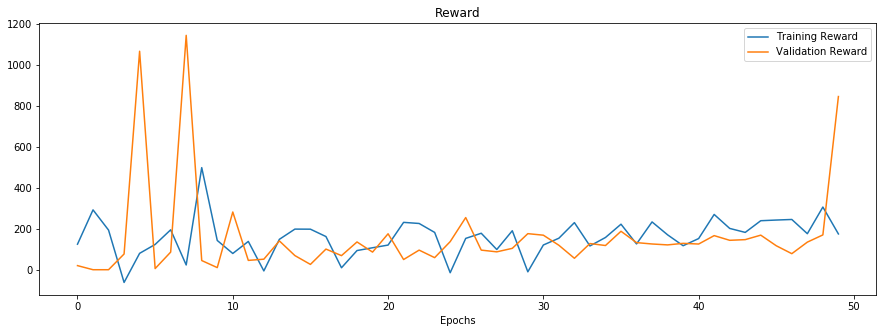

In [7]:
# Plotting Result
plt.figure(figsize = (15,5))
plt.plot(reslist_t, label = "Training Reward");
plt.plot(reslist_v, label = "Validation Reward");
plt.title("Reward")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Plotting the evaluation actions

I1001 22:01:39.397699 20704 evaluate.py:111] model_Stefan2: +$845.23

2019-10-01 22:01:39 PC-Stefan root[9980] INFO model_Stefan2: +$845.23



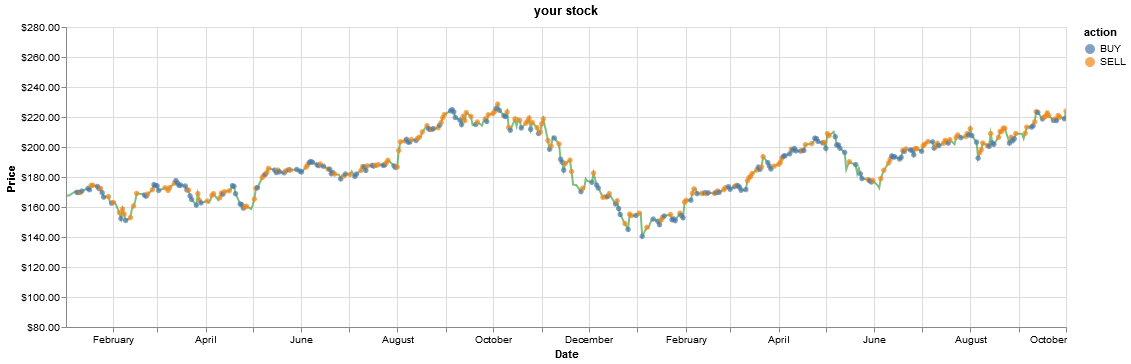

In [8]:
val_result, history = evaluate_model(agent, val_data,val_data2, window_size, debug)
show_eval_result(model_name, val_result, initial_offset)
chart = visualize(df, history)
chart

In [33]:
df.tail(200)

NameError: name 'df' is not defined

## Testing the Model
### Load different types of stocks in model:
 - Growth: Adobe (ADBE), Apple (AAPL)
 - Cyclical: Royal Caribbean (RCL)
 - Slow and low dividend: Costco (COST)
 - Turnaround: A&F (ANF)
 - Other: Gold
 
### Load generated data
  - Sin function
  - Random Data
 
 

<Figure size 432x288 with 0 Axes>

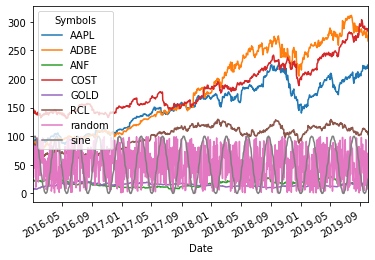

In [63]:
# Loading Test Data
# Setting Start and Enddate for Validation


start_test = datetime.datetime(2016, 1, 1)
end_test = datetime.datetime.now()

# Load Test Data

# Load several stocks
df_test = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_test, 
                               end=end_test)['Adj Close']

#Add random column for testing
df_test['random']=np.random.randint(1,100,df_test.shape[0])
df_test['sine']=50+50*np.sin(np.linspace(1,100,df_test.shape[0]))

# define second data input
df2_test = web.DataReader('GOLD','yahoo',
                               start=start_test, end=end_test)

# Convert df2_test to list
df2_test_list = list(df2_test['Adj Close'])


plt.figure();
df_test.plot();


In [64]:
print(df_test.tail(20))

Symbols           AAPL        ADBE        ANF        COST       GOLD  \
Date                                                                   
2019-09-05  213.279999  287.750000  15.420000  296.970001  18.400000   
2019-09-06  213.259995  284.940002  14.650000  303.760010  17.870001   
2019-09-09  214.169998  279.299988  16.170000  299.000000  17.410000   
2019-09-10  216.699997  276.140015  16.590000  297.000000  17.250000   
2019-09-11  223.589996  277.779999  17.160000  290.690002  17.340000   
2019-09-12  223.089996  278.019989  17.049999  289.890015  17.129999   
2019-09-13  218.750000  278.350006  17.709999  291.899994  17.230000   
2019-09-16  219.899994  282.929993  16.180000  288.690002  17.100000   
2019-09-17  220.699997  284.690002  16.240000  291.410004  18.020000   
2019-09-18  222.770004  279.720001  16.139999  292.429993  17.639999   
2019-09-19  220.960007  281.260010  15.990000  287.829987  18.299999   
2019-09-20  217.729996  277.910004  15.720000  286.359985  18.43

In [66]:
#Load Model
model_name = 'model_Stefan2_50'
# Init Model
window_size = 10



# Initialize Agent
if df2_test_list is not None:
    agent = Agent(window_size*2, pretrained=True, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=True, model_name=model_name)

sum = 0
# Loop over stocks
for column in df_test:
    print(column)
    #rename feature column name
    df_test_list = list(df_test[column])
    dft = df_test.rename(columns={column: 'actual'})
    initial_offset = df_test_list[1] - df_test_list[0]
    val_result, history = evaluate_model(agent, df_test_list, df2_test_list, window_size, debug)
    show_eval_result(model_name, val_result, initial_offset)
    chart = visualize(dft, history)
    sum = sum+val_result
    print("Earnings of Model: ", val_result)
    #chart.display()

print("Sum: ", sum)

AAPL
Earnings of Model:  6687.2548904418945
ADBE
Earnings of Model:  8318.409767150879
ANF
Earnings of Model:  -246.7281894683838
COST
Earnings of Model:  6082.1920166015625
GOLD
Earnings of Model:  14.468528270721436
RCL
Earnings of Model:  1295.575366973877
random
Earnings of Model:  6348
sine
Earnings of Model:  -1071.5571912719129
Sum:  27427.615188698637


In [87]:
def Randomizing():
    df = pd.DataFrame({"D1":range(5), "D2":range(5)})
    print(df)
    df2 = df.reindex(np.random.permutation(df.index))
    print(df2)

Randomizing()

   D1  D2
0   0   0
1   1   1
2   2   2
3   3   3
4   4   4
   D1  D2
0   0   0
2   2   2
1   1   1
3   3   3
4   4   4


In [91]:
df = pd.DataFrame({"D1":range(5), "D2":range(5)})
print(df)
print(df.columns.values)
cols = np.random.choice(df.columns.values, 2)
print(cols)
df200 = df[cols]
df200.head()


   D1  D2
0   0   0
1   1   1
2   2   2
3   3   3
4   4   4
['D1' 'D2']
['D1' 'D1']


,D1,D1
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
